## <h3 align="center">Statistical Analysis and Modeling of Neural Data (NEU 560)</h3>
<h4 align="center">Princeton University, Spring 2018</h4>
<h4 align="center">Jonathan Pillow</h4>

---
## Homework 3: Generalized Linear Models 
#### Due: Monday, 4/16 at 11:59pm



---
Before we start let's run some magic commands to automatically save our progress once a second (with `%autosave 1`), force all graphics from the `matplotlib` package to be displayed inline (with `%matplotlib notebook`), and then import some of our favorite packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%autosave 1
%matplotlib inline

Autosaving every 1 seconds


---
## Load some binned spike train data from primate retina

Load the file `RGCdata.mat`, which contains temporal binary white noise stimuli and the binned spike responses of 4 retinal ganglion cells (RGCs) recorded from a small patch of retina in vitro.  [Ref: Uzzell & Chichilnisky 2004]. It contains three variables:

$\quad \bullet$ `Stim` = a $T=144051 \times 1$ vector of full-filed stimulus intensities for a stimulus presented at approximately 120Hz (120 Frames per second), a stimulus commonly known as "full-field flicker".

$\quad \bullet$ `SpCounts` = a $144051 \times 4$ matrix of binned spike counts (each column has counts for a different cell: 2 ON cells, 2 OFF cells).

$\quad \bullet$ `dtStim` = the size of a single time bin (in seconds), needed for computing model output in units of spikes / s. The stimulus frame rate is given by 1/dtStim.


In [2]:
#Read in the variables from pdfData2D.mat
from scipy.io import loadmat
data = loadmat('RGCdata.mat')
Stim = data['Stim'].squeeze()
SpCounts = data['SpCounts'].squeeze()
dtStim = float(data['dtStim'])

## Fit linear-Gaussian regression Model 

**1)** Create the design matrix $X$ using $d=25$ time bins of the stimulus for each row.  That is, $X$ should be a $T \times d$ matrix, where each row is the relevant stimulus vector for predicting the response of a neuron on that trial. Assume values of `Stim`=0 for the 24 time bins prior to the first time bin of the response. (This is known as "zero-padding", so that the design matrix has the same number of rows as the response vectors in `SpCounts`.) Make an image plot showing the first 50 rows of the design matrix (i.e., a $50 \times 25$ matrix).

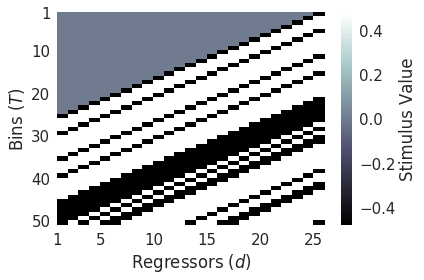

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Construct design matrix.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
d = 25
X = np.zeros((Stim.size,d))

## Construct design matrix.
for i in np.arange(d):
    X[:,i] = np.roll(Stim, i)
    X[:i,i] = 0
X = X[:,::-1]
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Intiialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot.
sns.heatmap(X[:50], cmap='bone', cbar_kws=dict(label='Stimulus Value'), ax=ax)
ax.set(xticks=[0,4,9,14,19,24], xticklabels=[1,5,10,15,20,25], xlabel='Regressors ($d$)',
       yticks=[0,9,19,29,39,49], yticklabels=[1,10,20,30,40,50], ylabel='Bins ($T$)')

plt.tight_layout()

**2)**  For neuron 1, compute the spike-triggered average,  $STA = Y^T X \,/\, \textrm{sum}(Y)$, where $Y$ is the vector of spike counts of the neuron (i.e., the first column of `SpCounts`)


In [4]:
Y = SpCounts[:,0].copy()
STA = (Y.T @ X) / Y.sum()

**3)** For the same neuron, compute the maximum likelihood estimate for the linear-Gaussian GLM (aka "general linear model"). 

Before you do so, add a column of 1's to the design matrix, so that your weights are augmented to include an additive constant (also known as a "DC term"). This additional weight, which we will refer to as $b$, will account for the mean of $Y$ (which is not zero, since the spike counts are all $\geq 1$).  

Plot the resulting ML filter estimate (just the 25-element weight vector $w$ on the stimulus elements, not the DC term $b$), after rescaling it to be a unit vector. Plot the STA (also rescaled to be a unit vector) on the same axes.  How much difference is there between the STA and the ML estimate?

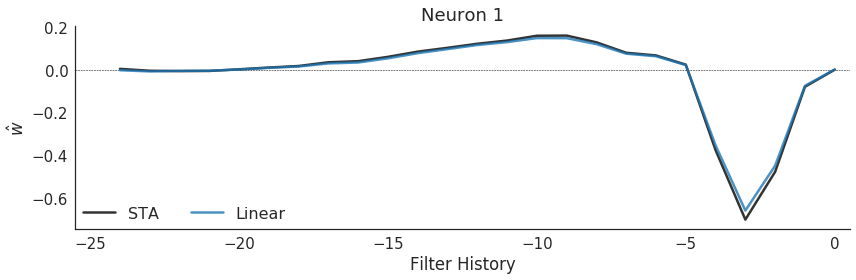

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Find MLE estimates.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Prepend 1-vector to design matrix.
X = np.concatenate([np.ones((Stim.size,1)), X], axis=-1)

## Compute MLE estimates.
w_linear = np.linalg.inv(X.T @ X) @ (X.T @ Y)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
colors = ['k', '#1f77b4', '#2ca02c', '#d62728']

## Iteratively plot.
for w, label, color in zip([STA.T, w_linear], ['STA','Linear'], colors):

    ## Convert to unit vector.
    w_norm = w / np.linalg.norm(w)
    if not label == 'STA': w_norm = w_norm[1:]

    ## Plot.
    x = np.arange(w_norm.size)[::-1] * -1
    ax.plot(x, w_norm, lw=2.5, label=label, color=color, alpha=0.8)

## Add info.
ax.hlines(0,-25.5,0.5,linestyle='--',lw=0.5,zorder=0)
ax.set(xlim=(-25.5,0.5), xlabel='Filter History', ylabel=r'$\hat{w}$', title='Neuron 1')
ax.legend(loc=3, ncol=4, fontsize=16, borderpad=0)
    
sns.despine()
plt.tight_layout()

## Poisson GLM

**5)** Write a function to compute negative log-likelihood of the spike train under the Poisson-GLM with exponential nonlinearity.  Your function should take in the weights $w$, the spike train $Y$, and the design matrix $X$ to compute $-\log P(Y|X,w)$. 

---

The PMF of the Poisson distribution is:

$$ Y \sim Poiss(\lambda) = \frac{1}{y!}\lambda^y e^{-\lambda} $$

Thus its negative log-likelihood is:

$$ -\text{log} \ p(y \mid X, w) = -\text{log}(y!^{-1}) - \text{log}(\lambda^y) - \text{log}(e^{-\lambda}) $$

$$ = \text{log}(y!) - y\text{log}(\lambda) + \lambda$$

If our model is the log-link (i.e. non-linear exponential) Poisson model, then our $\lambda$ is:

$$ \lambda = e^{xw} $$

Thus our negative log-likelihood becomes:

$$ -\text{log} \ p(y \mid X, w) = \text{log}(y!) - y\text{log}(e^{xw}) + e^{xw}$$

$$ = \text{log}(y!) - ywx + e^{xw}$$

In vector form, substituting $x$, $y$, and $w$ for $X$, $Y$, and $\vec{w}$:

$$ = \sum_i^n \text{log}(y_i!) - Y^TX\vec{w} + \vec{1}^Te^{X \vec{w}}$$

In the function below, we will drop constants. To speed up optimization, we also compute the Jacobian:

$$ \frac{d}{dw} \ e^{X \vec{w}} - Y^TX\vec{w} $$

$$ = e^{X \vec{w}}X - Y^TX $$


In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define exponential Poisson logpdf.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def exp_poiss_lpdf(w, X, Y):
    '''Exponential Poisson negative log-likelihood'''
    return np.sum(np.exp(X @ w)) - Y.T @ X @ w

def exp_poiss_der(w, X, Y):
    '''Exponential Poisson negative log-likelihood derivative'''
    return np.exp(X @ w) @ X - Y.T @ X

def ExpPoiss(w, X, Y):
    return exp_poiss_lpdf(w, X, Y), exp_poiss_der(w, X, Y)

**6)** Use `scipy.optimize` to find the maximum-likelihood estimate of the weight vector $w$ under the Poisson GLM, using the function you wrote in the previous problem.  Be sure to use the design matrix augmented with a column of 1s so that your model includes an additive constant.  

Plot the filter estimate on the same axes as the STA and linear-Gaussian model estimate (with all three vectors rescaled to be unit vectors, so that we aren't distracted by differences in their amplitude).

Convergence = True


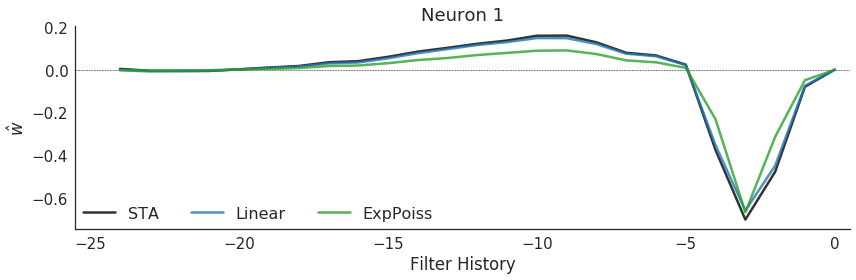

In [7]:
from scipy.optimize import minimize

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Find MLE estimates.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)
    
## Sample initial weights.
w0 = np.random.normal(0,0.5,X.shape[-1])

## Find maximum likelihood. 
result = minimize(ExpPoiss, w0, args=(X, Y), method='Newton-CG', jac=True)
print('Convergence = %s' %result.success)

## Store.
w_exppoiss = result.x.copy()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
colors = ['k', '#1f77b4', '#2ca02c', '#d62728']

## Iteratively plot.    
for w, label, color in zip([STA.T, w_linear, w_exppoiss], ['STA','Linear','ExpPoiss'], colors):
        
    ## Convert to unit vector.
    w_norm = w / np.linalg.norm(w)
    if not label == 'STA': w_norm = w_norm[1:]

    ## Plot.
    x = np.arange(w_norm.size)[::-1] * -1
    ax.plot(x, w_norm, lw=2.5, label=label, color=color, alpha=0.8)

## Add info.
ax.hlines(0,-25.5,0.5,linestyle='--',lw=0.5,zorder=0)
ax.set(xlim=(-25.5,0.5), xlabel='Filter History', ylabel=r'$\hat{w}$', title='Neuron 1')
ax.legend(loc=3, ncol=4, fontsize=16, borderpad=0)
    
sns.despine()
plt.tight_layout()

**6)** Now write a second function to compute the negative log-likelihood for the Poisson GLM that uses the nonlinearity $f(x) = \log(1+\exp(x))$. This function grows linearly for large positive $x$ but decays slowly to 0 for negative $x$, and is therefore known as the "soft-rectification" function, or alternately as the "soft-plus function".  You can simply alter your function above, or else write a more general function that takes in the nonlinearity as on of the arguments.

Use `scipy.optimize` to find the maximum-likelihood estimate of the weight vector $w$ and constant $b$ under this second Poisson GLM.  Which model (with exponential or soft-plus nonlinearity) achieves higher log-likelihood (or equivalently, lower negative log-likelihood)? Plot the two Poisson-GLM filter estimates on the same axes.

---

Again if our negative log-likelihood is:

$$ = \text{log}(y!) - y\text{log}(\lambda) + \lambda$$

And our model is soft-plus Poisson, then our $\lambda$ is:

$$ \lambda = \text{log}(1 + e^{xw}) $$

Then our negative log-likelihood becomes:

$$ -\text{log} \ p(y \mid X, w) = \text{log}(y!) - y\text{log}(\text{log}(1 + e^{xw})) + \text{log}(1 + e^{xw})$$

In vector form, substituting $x$, $y$, and $w$ for $X$, $Y$, and $\vec{w}$:

$$ = \sum_i^n \text{log}(y_i!) - Y^T \text{log} \left( \text{log}(1 + e^{X\vec{w}}) \right) + \vec{1}^T \text{log}(1 + e^{xw})$$

In the function below, we will drop constants. To speed up optimization, we also compute the Jacobian. It turns out that the derivative of the softplus function is the logistic function: $\frac{1}{1 + e^{-x}}$.

$$ \frac{d}{dw} \ \text{log}(1 + e^{xw}) - Y^T \text{log} \left( \text{log}(1 + e^{X\vec{w}}) \right)$$

$$ = \left( \frac{1}{1 + e^{-X\vec{w}}} \right) X - \left( \frac{Y}{(1 + e^{-X\vec{w}}) \cdot \text{log}(1 + e^{X\vec{w}})} \right) X $$


Convergence = True
Log-likelihood ExpPoiss: mu = -48431
Log-likelihood SoftPlus: mu = -46846


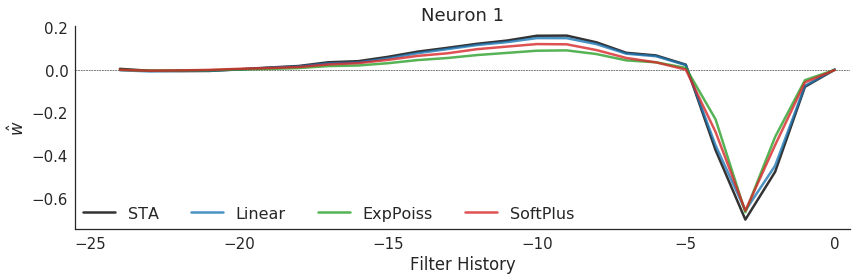

In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define SoftPlus logpdf.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def logistic(arr):
    return 1 / (1 + np.exp(-arr))

def soft_plus_lpdf(w, X, Y):
    '''Softplus exponential negative log-likelihood'''
    return np.sum(np.logaddexp(0, X @ w)) - Y.T @ np.log(np.logaddexp(0, X @ w)) 

def soft_plus_lpdf_der(w, X, Y):
    '''Softplus exponential negative log-likelihood derivative'''
    a = logistic(X @ w) @ X
    b = (Y * logistic(X @ w) / np.logaddexp(0, X @ w)) @ X
    return a - b

def SoftPlus(w, X, Y):
    return soft_plus_lpdf(w, X, Y), soft_plus_lpdf_der(w, X, Y)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Find MLE estimates.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)
    
## Sample initial weights.
w0 = np.random.normal(0,0.5,X.shape[-1])

## Find maximum likelihood. 
result = minimize(SoftPlus, w0, args=(X, Y), method='Newton-CG', jac=True)
print('Convergence = %s' %result.success)

## Store.
w_softplus = result.x.copy()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compare log-likelihoods.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute log-likelihoods.
lpdf_exppoiss = -exp_poiss_lpdf(w_exppoiss, X, Y)
lpdf_softplus = -soft_plus_lpdf(w_softplus, X, Y)

## Print info.
print('Log-likelihood ExpPoiss: mu = %0.0f' %lpdf_exppoiss)
print('Log-likelihood SoftPlus: mu = %0.0f' %lpdf_softplus)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
colors = ['k', '#1f77b4', '#2ca02c', '#d62728']

## Iteratively plot.    
for w, label, color in zip([STA.T, w_linear, w_exppoiss, w_softplus], 
                           ['STA','Linear','ExpPoiss','SoftPlus'], colors):
        
    ## Convert to unit vector.
    w_norm = w / np.linalg.norm(w)
    if not label == 'STA': w_norm = w_norm[1:]

    ## Plot.
    x = np.arange(w_norm.size)[::-1] * -1
    ax.plot(x, w_norm, lw=2.5, label=label, color=color, alpha=0.8)

## Add info.
ax.hlines(0,-25.5,0.5,linestyle='--',lw=0.5,zorder=0)
ax.set(xlim=(-25.5,0.5), xlabel='Filter History', ylabel=r'$\hat{w}$', title='Neuron 1')
ax.legend(loc=3, ncol=4, fontsize=16, borderpad=0)
    
sns.despine()
plt.tight_layout()

**7)** Examine the nonlinearity used by the two Poisson by making a scatter plot of $Xw$ against $f(Xw)$  (where each element of $Xw$ is $\vec x_i \cdot \vec w + b$), for both of the nonlinearities considered above.  The x axis label of your plots should be "stimulus filter output" and y axis label output should be "spike rate (sp/bin).  If you'd like you can divide the y points by `dtStim` so that the y axis has units of (sp/sec).




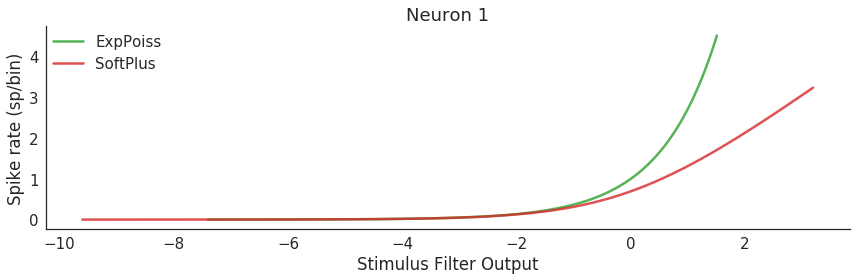

In [9]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
colors = ['k', '#1f77b4', '#2ca02c', '#d62728']

## Iteratively plot.
for w, f, label, color in zip([w_exppoiss, w_softplus], [lambda x: np.exp(x), lambda x: np.logaddexp(0,x)], 
                              ['ExpPoiss','SoftPlus'], colors[-2:]):

    ## Compute.
    x = np.sort(X @ w)
    fx = f(x)

    ## Plot.
    ax.plot(x, fx, lw=2.5, label=label, color=color, alpha=0.8)

## Add info.
ax.set(xlabel='Stimulus Filter Output', ylabel='Spike rate (sp/bin)', title='Neuron 1')
ax.legend(loc=2, borderpad=0)
    
sns.despine()
plt.tight_layout()

**8)**  Now make a non-parametric estimate of the nonlinearity using the method we discussed in class: make a histogram of the values of $Xw$; then, in each histogram compute the average spike count of the stimuli that landed in that bin.  Do this separately for each nonlinearity, and make a plot showing the parametric nonlinearity ($\exp(x)$ or $\log(1+\exp(x))$) on the same axes as the histogram-based nonparametric estimate.  (I'd recommend using say 25-50 bins for the histogram, though you can experiment with using more or fewer bins to see how this changes the shape of the nonparametric estimate).


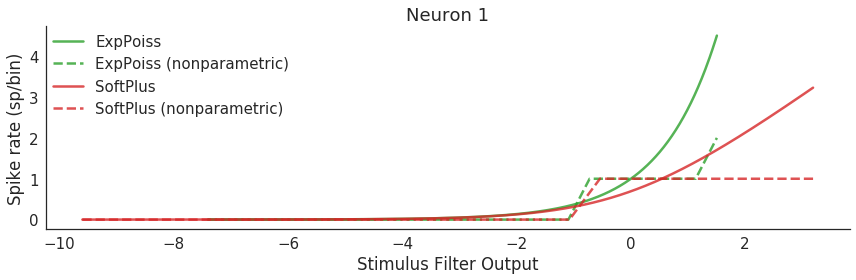

In [10]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
colors = ['k', '#1f77b4', '#2ca02c', '#d62728']

## Iteratively plot.
for w, f, label, color in zip([w_exppoiss, w_softplus], [lambda x: np.exp(x), lambda x: np.logaddexp(0,x)], 
                              ['ExpPoiss','SoftPlus'], colors[-2:]):
        
    ## Compute.
    x = X @ w
    fx = f(x)
    ix = np.argsort(x)

    ## Plot.
    ax.plot(x[ix], fx[ix], lw=2.5, label=label, color=color, alpha=0.8)

    ## Compute non-parametric estimate.
    bins = np.linspace(x.min(), x.max(), 25)
    categories = np.digitize(x, bins)
    spike_rate = [np.median(Y[categories==i]) for i in np.unique(categories)]
    ax.plot(bins, spike_rate, lw=2.5, linestyle='--', label='%s (nonparametric)' %label, 
            color=color, alpha=0.8)

## Add info.
ax.set(xlabel='Stimulus Filter Output', ylabel='Spike rate (sp/bin)', title='Neuron 1')
ax.legend(loc=2, borderpad=0)
    
sns.despine()
plt.tight_layout()


## Adding spike-history to the GLM

**9)**  Augment the design matrix $X$ to include 20 bins of spike-history from neuron 1 (i.e. grab the previous 20 time bins of $Y$ for time bin, and insert them into the design matrix).  Fit the Poisson-GLM (with exponential nonlinearity) using this larger design matrix. Plot the stimulus filter, and the spike-history filter.  How much higher is the log-likelihood of this new model?  

Convergence = True
Log-likelihood ExpPoiss: mu = -48431
Log-likelihood ExpPoiss Spike History: mu = -44832


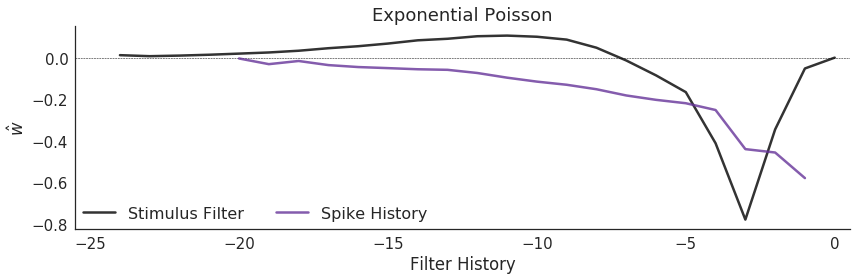

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Construct design matrix.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Make copy.
Xh = np.copy(X)

## Design spike-history filter.
H = np.zeros((Xh.shape[0], 20))
for i in np.arange(20):
    H[:,i] = np.roll(Y, i+1)
    H[:i,i] = 0
H = H[:,::-1]

## Concatenate.
Xh = np.concatenate([Xh, H], axis=-1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Find MLE estimates.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Sample initial weights.
w0 = np.concatenate([w_exppoiss, np.random.normal(0,0.5,20)])

## Find maximum likelihood. 
result = minimize(ExpPoiss, w0, args=(Xh, Y), method='Newton-CG', jac=True)
print('Convergence = %s' %result.success)

## Store.
w_sh = result.x.copy()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compare log-likelihoods.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute log-likelihood.
lpdf_sh = -exp_poiss_lpdf(w_sh, Xh, Y)

## Print info.
print('Log-likelihood ExpPoiss: mu = %0.0f' %lpdf_exppoiss)
print('Log-likelihood ExpPoiss Spike History: mu = %0.0f' %lpdf_sh)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
colors = ['k', 'rebeccapurple', '#1f77b4', '#2ca02c', '#d62728']

## Iteratively plot.        
for w, label, color in zip([w_sh[1:26], w_sh[-20:]], ['Stimulus Filter', 'Spike History'], colors):

    ## Convert to unit vector.
    w_norm = w / np.linalg.norm(w)

    ## Plot.
    x = np.arange(w_norm.size)[::-1] * -1
    if not label == 'Stimulus Filter': x += -1
    ax.plot(x, w_norm, lw=2.5, label=label, color=color, alpha=0.8)

## Add info.
ax.hlines(0,-25.5,0.5,linestyle='--',lw=0.5,zorder=0)
ax.set(xlim=(-25.5,0.5), xlabel='Filter History', ylabel=r'$\hat{w}$', title='Exponential Poisson')
ax.legend(loc=3, ncol=4, fontsize=16, borderpad=0)
    
sns.despine()
plt.tight_layout()

**10)** Now augment the design matrix again to incorporate 20 time-bins of spike history from each of the three other neurons (whose spikes are contained in columns 2 through 4 of `SpCounts`.)  Your design matrix now has columns corresponding to the constant $b$, the stimulus filter $w$, the self-coupling spike-history filter $h_1$, and the coupling filters from the other neurons $h_2$, $h_3$, and $h_4$.  Compute the maximum likelihood estimate of all parameters of this augmented model, and plot the four filters you obtain. Which coupling filters indicate a positive coupling and which indicate negative coupling?  Once again, how much higher is the log-likelihood of this fully coupled model? 

Convergence = True
Log-likelihood ExpPoiss: mu = -48431
Log-likelihood ExpPoiss Spike History: mu = -44832
Log-likelihood ExpPoiss Full Model: mu = -44386


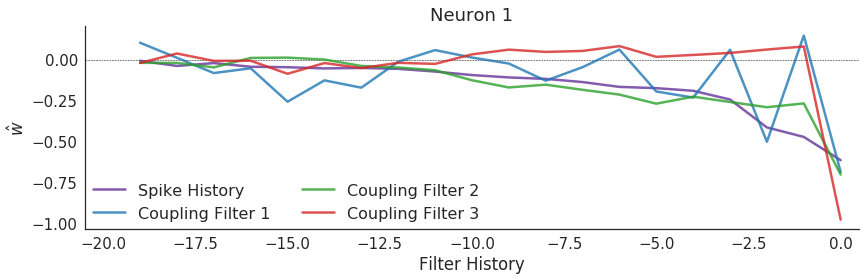

In [12]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Construct design matrix.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Make copy.
Xh = np.copy(X)

## Iterate over neurons.
for i in np.arange(4):

    ## Design spike-history filter.
    H = np.zeros((Xh.shape[0], 20))
    for j in np.arange(20):
        H[:,j] = np.roll(SpCounts[:,i], j+1)
        H[:j,j] = 0
    H = H[:,::-1]

    ## Concatenate.
    Xh = np.concatenate([Xh, H], axis=-1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Find MLE estimates.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Sample initial weights.
w0 = np.concatenate([w_exppoiss, w_sh[-20:], np.random.normal(0,0.5,60)])

## Find maximum likelihood. 
result = minimize(ExpPoiss, w0, args=(Xh, Y), method='Newton-CG', jac=True)
print('Convergence = %s' %result.success)

## Store.
w_exppoiss_full = result.x.copy()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compare log-likelihoods.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute log-likelihood.
lpdf_exppoiss_full = -exp_poiss_lpdf(w_exppoiss_full, Xh, Y)

## Print info.
print('Log-likelihood ExpPoiss: mu = %0.0f' %lpdf_exppoiss)
print('Log-likelihood ExpPoiss Spike History: mu = %0.0f' %lpdf_sh)
print('Log-likelihood ExpPoiss Full Model: mu = %0.0f' %lpdf_exppoiss_full)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
colors = ['k', 'rebeccapurple', '#1f77b4', '#2ca02c', '#d62728']

## Iteratively plot.
for w, label, color in zip([w_exppoiss_full[-80:-60], w_exppoiss_full[-60:-40], 
                            w_exppoiss_full[-40:-20], w_exppoiss_full[-20:]], 
                           ['Spike History']+['Coupling Filter %s' %i for i in np.arange(3)+1], 
                           colors[1:]):

    ## Convert to unit vector.
    w_norm = w / np.linalg.norm(w)

    ## Plot.
    x = np.arange(w_norm.size)[::-1] * -1
    ax.plot(x, w_norm, lw=2.5, label=label, color=color, alpha=0.8)

## Add info.
ax.hlines(0,-20.5,0.5,linestyle='--',lw=0.5,zorder=0)
ax.set(xlim=(-20.5,0.5), xlabel='Filter History', ylabel=r'$\hat{w}$', title='Neuron 1')
ax.legend(loc=3, ncol=2, fontsize=16, borderpad=0)
    
sns.despine()
plt.tight_layout()

**11)** Compute the standard deviation of the output of the stimulus filter (i.e., the relevant columns of $X$ times the fitted stimulus filter $w$) and compare it to the standard deviation of the spike-history filter (the neuron's spike history columns of $X$ multiplied by $h_1$) and the standard deviation of the total output from the three coupling filters.  This gives a sense of how large the drive is from each of these three kinds of regressors (stimulus, spike history, and spike-history of other neurons).  Make a bar graph showing these three standard deviations you obtained.

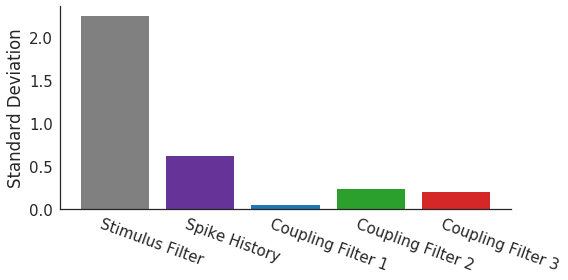

In [13]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute standard deviations.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define indices.
indices = [(1,26),(-80,-60),(-60,-40),(-40,-20),(-20,106)]

## Iteratively compute standard deviation.
sd = np.array([ np.std(Xh[:,i:j] @ w_exppoiss_full[i:j]) for i, j in indices ])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))
colors = ['grey', 'rebeccapurple', '#1f77b4', '#2ca02c', '#d62728']
labels = ['Stimulus Filter','Spike History']+['Coupling Filter %s' %i for i in np.arange(3)+1]

## Plot.
ax.bar(np.arange(sd.size), sd, color=colors)
ax.set(xticks=np.arange(5)-0.2, ylabel='Standard Deviation')
ax.set_xticklabels(labels, rotation=-20, ha='left')

sns.despine()
plt.tight_layout()

**12)** Repeat the steps in question 10 (fitting the fully coupled model and plotting the filters obtained) but using the Poisson GLM with softplus nonlinearity.  Which model achieves higher log-likelihood?

In [14]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Find MLE estimates.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Sample initial weights.
w0 = np.concatenate([w_softplus, w_sh[-20:], np.random.normal(0,0.5,60)])

## Find maximum likelihood. 
result = minimize(SoftPlus, w0, args=(Xh, Y), method='Newton-CG', jac=True)
print('Convergence = %s' %result.success)

## Store.
w_softplus_full = result.x.copy()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compare log-likelihoods.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute log-likelihood.
lpdf_softplus_full = -exp_poiss_lpdf(w_softplus_full, Xh, Y)

## Print info.
print('Log-likelihood ExpPoiss Full Model: mu = %0.0f' %lpdf_exppoiss_full)
print('Log-likelihood ExpPoiss Full Model: mu = %0.0f' %lpdf_softplus_full)

Convergence = True
Log-likelihood ExpPoiss Full Model: mu = -44386
Log-likelihood ExpPoiss Full Model: mu = -62161


---
## Regularization

Now load the data contained in `RGCdataHi.mat` and extract the variables `StimHi`, `SpCountHi`, and `dtStimHi`.  These variables contain the same stimuli and spike trains analyzed above, but upsampled by a factor of 10 (i.e. so time bins are 10 times smaller).  On this timescale the stimuli large temporal correlations because the stimulus values in `StimHi` only change every 10 bins.  This means that the stimulus lacks power at high-frequencies, and we will need to regularize. (Note that I truncated these variables to include only the first minute of data from the previous dataset).

**13)** Load the data.  Plot the first 1 second of the stimulus and spike train of neuron 1.

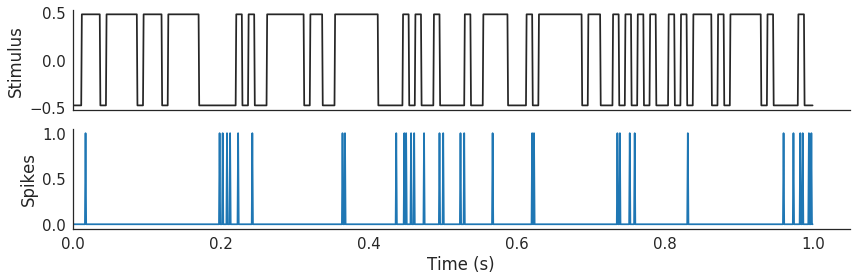

In [15]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
mat = loadmat('RGCdataHi.mat')
StimHi = mat['StimHi'].squeeze()
SpCountsHi = mat['SpCountsHi'].squeeze()
dtStimHi = float(mat['dtStimHi'])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2,1,figsize=(12,4),sharex=True)

## Plotting features.
n_pts = int(np.ceil(1 / dtStimHi))
times = np.arange(n_pts) * dtStimHi
colors = ['0.15', '#1f77b4']

## Plot.
for ax, arr, ylabel, color in zip(axes, [StimHi[:n_pts],SpCountsHi[:n_pts,0]], 
                                  ['Stimulus','Spikes'], colors):
    
    ax.plot(times, arr, color=color)
    ax.set(xlim=(0), ylabel=ylabel)
    
ax.set(xlabel='Time (s)')
sns.despine()
plt.tight_layout()

**14)** Compute the design matrix for this new dataset (using just the stimulus), now including 250 time bins of the stimulus history.  Compute the STA and ML estimate under the linear Gaussian model and plot them on the same axes (rescaled to be unit vectors).  Do these look similar?

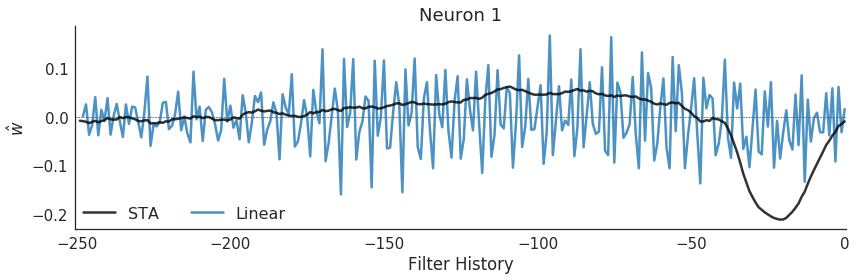

In [16]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Construct design matrix.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
d = 250
X = np.zeros((StimHi.size,d))

## Construct design matrix.
for i in np.arange(d):
    X[:,i] = np.roll(StimHi, i)
    X[:i,i] = 0
X = X[:,::-1]
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute spike-triggered average.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
Y = SpCountsHi[:,0].copy()
STA = (Y.T @ X) / Y.sum()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Find MLE estimates.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute MLE estimates.
w_linear = np.linalg.inv(X.T @ X) @ (X.T @ Y)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
colors = ['k', '#1f77b4']

## Iteratively plot.
for w, label, color in zip([STA.T, w_linear], ['STA','Linear'], colors):

    ## Convert to unit vector.
    w_norm = w / np.linalg.norm(w)
    if not label == 'STA': w_norm = w_norm[1:]

    ## Plot.
    x = np.arange(w_norm.size)[::-1] * -1
    ax.plot(x, w_norm, lw=2.5, label=label, color=color, alpha=0.8, zorder=10 if label=='STA' else 1)

## Add info.
ax.hlines(0,-250.5,0.5,linestyle='--',lw=0.5,zorder=0)
ax.set(xlim=(-250.5,0.5), xlabel='Filter History', ylabel=r'$\hat{w}$', title='Neuron 1')
ax.legend(loc=3, ncol=4, fontsize=16, borderpad=0)
    
sns.despine()
plt.tight_layout()

## Ridge regression

**15)**  Divide your data into a training set (80%) and test set (20%).  Set up a grid of $\lambda$ values ($\lambda_1, \lambda_2, \ldots, \lambda_m)$ and compute the ridge regression estimate of the weights (aka the MAP estimate under a Gaussian prior with covariance $(1/\lambda) I$ for each $\lambda_j$.  Can you make a movie showing how $\hat w_{MAP}$ changes with $\lambda$?  (If this is too difficult then just make plots showing how the MAP estimate changes with $\lambda$.

$$ \hat{w}_{ridge} = \left( X^TX + \lambda^{-1}I \right)^{-1} X^TY $$

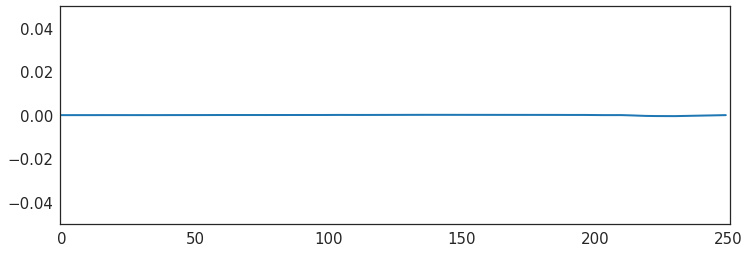

In [17]:
from matplotlib import animation
from IPython.display import HTML
from sklearn.model_selection import train_test_split

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define MLE ridge regression.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def RidgeRegression(X, Y, penalty):
    return np.linalg.inv(X.T @ X + np.diag(np.ones(X.shape[-1])*penalty)) @ X.T @ Y

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Perform ridge regression.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Divide data.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=10101)

## Define penalty grid.
lambdas = np.logspace(0, 6, 21)

## Iteratively 
w_ridge = np.array([RidgeRegression(X_train, Y_train, lmb) for lmb in lambdas])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define animation functions.
def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    line.set_data(np.arange(w_ridge[i].size), w_ridge[i])
    return (line,)

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.hlines(0,-250.5,0.5,linestyle='--',lw=0.5,zorder=0)
ax.set(xlim=(-0.5,250.5), ylim=(-0.05,0.05))

## Initialize line.
line, = ax.plot([], [], lw=2);

## Animate.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=lambdas.size, 
                               interval=100, blit=True);
HTML(anim.to_jshtml())

**16)** To determine the optimal value of $\lambda$, make a plot of the test-error-per-sample, $||Y_{test}- X_{test} \hat w||^2$ divided by the number of bins in the test set, as a function of $\lambda$.  Make sure your $\lambda$ range is wide enough to capture a few values on either side of the global minimum.  (Note that this differs slightly from what we discussed in class, which was plotting test *log-likelihood*, but with Gaussian noise model it is fairly common to compute mean squared error, which is (after all) just a scaled version of the negative of the log-likelihood).  On the same axes, plot the training error per sample.  Do these curves have the same shape we discussed in class?

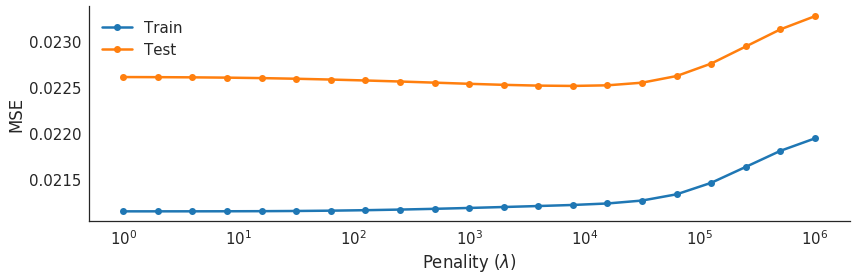

In [18]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Perform ridge regression.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
 
e_train, e_test = np.zeros((2,lambdas.size))
    
## Iteratively fit.
for i, lmb in enumerate(lambdas):
    
    ## Fit model.
    w_ridge = RidgeRegression(X_train, Y_train, lmb)
    
    ## Compute training error.
    e_train[i] = np.linalg.norm(Y_train - X_train @ w_ridge) ** 2 / Y_train.size
    
    ## Compute test error.
    e_test[i] = np.linalg.norm(Y_test - X_test @ w_ridge) ** 2 / Y_test.size

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4),sharex=True,sharey=True)

## Plotting.
ax.plot(lambdas, e_train, marker='o', lw=2.5, label='Train')
ax.plot(lambdas, e_test,  marker='o', lw=2.5, label='Test')
ax.set_xscale('log')
ax.set(xlabel='Penality ($\lambda$)',  ylabel='MSE')
ax.legend(loc=2)

sns.despine()
plt.tight_layout()

## Smoothing regularization

**18)** Generate the $250\times 250$ graph Laplacian matrix $L$ that computes the sum of squared differences in $\vec w$ via $\vec w^T L \vec w$.  

Verify that when you generate a random $\vec w$ vector, you get the same value if you compute $\sum_{i=2}^{250} (w_i-w_{i-1})^2$ as  $\vec w^T L \vec w$

In [19]:
T = 250

## Construct adjacency matrix.
A = np.diag(np.ones(T-1), k=1)
A += A.T

## Construct degree matrix.
D = np.diag(np.sum(A, axis=0))

## Construct graph laplacian.
L = D - A

## Confirm the same.
w = np.random.normal(0, 1, (T,1))
print(np.allclose(np.power(np.diff(w.squeeze()),2).sum(), w.T @ L @ w))

True


**17)** Now repeat the steps you took in problems 15-16 to perform cross-validation under the smoothing prior for a grid of different $\lambda$ values, where (now) the inverse covariance matrix is given by $\lambda L$.  Plot the curve of test error per sample and training error per sample as a function of $\lambda$, and plot a few of the $\hat w_{map}$ estimates, one below the minimum, one at the minimum, and one above the minimum of the test error curve.  Which estimate achieves a better estimate in terms of test error, the optimal ridge prior estimate or the optimal smoothing prior estimate?  

$$ \hat{w}_{UGL} = \left( X^TX + \lambda^{-1} L^{-1} \right)^{-1} X^TY $$

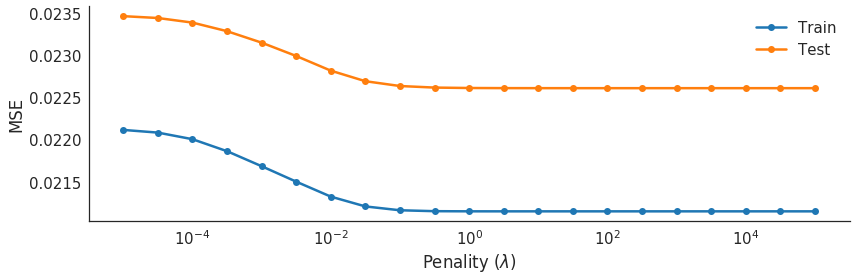

In [20]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define MLE UGL regression.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def UGLRegression(X, Y, L, penalty):
    return np.linalg.inv(X.T @ X + (1/penalty) * np.linalg.pinv(L)) @ X.T @ Y

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Perform UGL regression.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define penalty grid.
lambdas = np.logspace(-5,5,21)

## Compute error.
e_train, e_test = np.zeros((2,lambdas.size))
 
## Iteratively fit.
for i, lmb in enumerate(lambdas):
    
    ## Fit model.
    w_ugl = UGLRegression(X_train, Y_train, L, lmb)
    
    ## Compute training error.
    e_train[i] = np.linalg.norm(Y_train - X_train @ w_ugl) ** 2 / Y_train.size
    
    ## Compute test error.
    e_test[i] = np.linalg.norm(Y_test - X_test @ w_ugl) ** 2 / Y_test.size

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4),sharex=True,sharey=True)

ax.plot(lambdas, e_train, marker='o', lw=2.5, label='Train')
ax.plot(lambdas, e_test,  marker='o', lw=2.5, label='Test')
ax.set_xscale('log')
ax.set(xlabel='Penality ($\lambda$)',  ylabel='MSE')
ax.legend(loc=1)

sns.despine()
plt.tight_layout()